# From Scratch Series

## 2. Neural  Networks

Here, we will attempt to formulate a intuitive understanding of what exactly a neural network is, along with building and explaining each component that forms part of the neural network.

As part of this exercise, we will use the MNIST dataset which is a collection of images of handwritten digits and teach a neural network to recognise handwritten digits by analysing the pixels of the image.

First, we load up our numpy libraries for abstracting out basic operations like matrix multiplications & array handling, along with matplotlib for plotting  images. We also use tensorflow here, which is not strictly required - we simply use it because it saves us a lot of effort in having to write code to load the MNIST datasets.


In [1]:
import numpy as np
import matplotlib as mtl
import pandas as pd

In [2]:
from matplotlib import pyplot
from IPython.display import display, HTML, Markdown # For printing nice looking tables from pandas dataframes
from tensorflow.examples.tutorials.mnist import input_data

We now use tensorflow functions to automatically download the MNIST data from its hosting website, and load it into memory as a "Dataset" object.

In [6]:
mnist = input_data.read_data_sets("../data/MNIST_data/", one_hot=True)

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz


Let's examine what the data looks like first...

In [7]:
mnist.train.images.shape

(55000, 784)

In [8]:
mnist.train.images[1:2,:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

### A note on the MNIST dataset

The MNIST dataset is a labelled collection of images of digits from 0 to 9, which were handwritten by different individuals and then photographed and painstakingly labelled. Identifying handwritten numbers are usually a very simple task for human beings in most cases, so we tend to underestimate the complexity of how we perform visual recognition, which is a product of millions of years of evolution. Since computers are designed to follow a set of instructions in a strict order, the task of visual recognition needs to be broken down into a set of fixed business rules that the computer needs to check before making an inference. However, given that everyone has their own distinctive style of writing numbers, it is very difficult to formulate a commbination of business rules that accounts for every possibility without adding enormous complexity to the visual recognistion problem. This is where the utility of neural networks come in.

The tensorflow helper scripts read in the MNIST images (a set of 55,000 images), each of which is 28 by 28 pixels. The images are stored in terms of pixels, each of which are stored as greyscale values on 28 * 28 = 784 columns. There are 55000 such images, which form 55000 rows.

First, we'll write a function that reads in a row of the dataset and create an image from it.

In [3]:
def show_image(pixels, width, height):
    
    image = pixels.reshape(width, height)
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    ax.imshow(image, cmap = mtl.cm.Greys)
    pyplot.show()

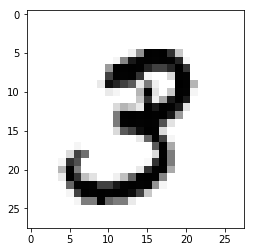

In [10]:
show_image(mnist.train.images[1,:], 28, 28)

Looks good. We know this is a 3, but the computer doesn't, yet. 

### First, the Neuron

We can start off by defining what a single neuron is. A neuron can be thought of as an object that holds a number - and this number signifies how active or excited the object is.  Higher the value of this number, more active the neuron is, and vice versa. The neuron object has an input port which can be used to control how excited the neuron becomes. A function that takes this input and turns it into the activation level of the neuron is called the activation function. This activation or excitation level then becomes the output of the neuron.

For now, let us assume that the limits of how excited a neuron can become as a result of any input is bounded within the range \[0, 1\]. So, for any numeric input to the neuron, we need to design an activation function that takes this numerical input and squishes it into a number between 0 and 1. We can think of the state 0 as the state of the neuron being completely inactive, and 1 as the state of neuron being fully active. 

Let us design this activation function now. For now, the only requirement we have is that for any input, the function squishes the input into a number between 0 and 1. There is a very familiar function that maps an arbitrary input into \[0, 1\] interval - the **logit** function which is commonly used in logistic regression.


\begin{align}
f(x) = \frac{1}{1 + e^{-k(x - x_0)} }
\end{align}

For keeping things simple, we use k=1, and x<sub>0</sub> = 0 as default for now, which makes the equation

\begin{align}
f(x) = \frac{1}{1 + e^{x} } = \sigma(x)
\end{align}

We call this special case of the logit function as the **sigmoid**, and use a $\sigma$ to represent it. Let us write some code to implement this function.

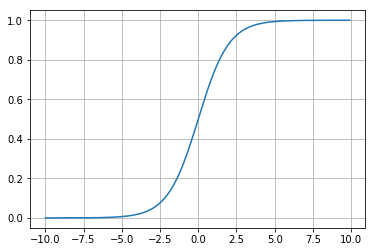

In [5]:
def sigmoid(x):
    return 1./(1. + np.exp(-1.* x) )

pyplot.plot(np.arange(-10, 10, 0.1), sigmoid(np.arange(-10, 10, 0.1)))
pyplot.grid(True)
pyplot.show()

### The neural network

A neural network, as the name suggests, is a set of interconnected neurons like the one we just created. As you may already be aware, such a network is inspired from biological nervous systems which consist of interlinked neuron cells, and the strengths of these connections may vary depending on various factors.

The artificial neural network we are constructing here also be be thought of as a bunch of artificial neurons that are linked to each other, with each link having an associated strength. When the output from one neuron passes to the subsequent neuron, it gets scaled by the strength of the link that connects the two neurons. This strength is called the **weight** of the link, and the weight is also just a numerical value similar to activation levels.

As an example, consider a simple case with 2 neurons connected to each other through a link, and let the weight of the link be 'w'. For an input 'x' to neuron 1, the activation function squishes x into an number between 0 and 1, and this output of neuron 1 is then fed to neuron 2 through the link. The output is hence scaled by the weight of the link 'w', and becomes the input to neuron 2. Now the activation function of neuron 2 picks up this value and squishes it to \[0, 1\], which is the output of neuron 2.

So the output becomes $ \sigma_2( \sigma_1(x) * w) ) $.



In [6]:
#Create a 2 neuron network, with 'x' as input and 'w' as weight of the link between the 2 neurons
def simplest_neural_network(x, w):
    return sigmoid(sigmoid(x)*w)

print("Large input: x=20 gives ", simplest_neural_network(x = 20, w = 4)) 
print("Small input: x=-20 gives ", simplest_neural_network(x = -20, w = 4)) 


Large input: x=20 gives  0.982013789892
Small input: x=-20 gives  0.500000002061




Now we're ready to start imagining slightly more complex neural network structures. To start with, we can imagine an easily comprehensible structure for the neural network (as opposed to imagining it as a messy interconnection of neurons like structure of our own brains). We do this by defining 3 layers of neurons in our network-

1. an input layer of neurons (which can be thought of as our data inputs), 
2. a middle layer of neurons which are connected to the input layer through a set of weighted links (called the hidden layer), 
3. an output layer of neurons which are  connected to the middle layer through another set of linked weights. 

Here, we link every input neuron with every hidden layer neuron, and the same is true for the linking between the hidden layer and the output layer. This means that if there are 'm' input neurons and 'n' hidden layer neurons, the there are m * n links between the two layers. The outputs from the output layer form the result generated by the network.

In the beginning, we can initialise all the weights to random numbers drawn from a standard normal distribution.

In [7]:
class Neuralnetwork():
    
    def __init__(self, config):        
        np.random.seed(12345)
        # Let  us restrict ourselves to 1 hidden layer
        self.input_layer = config[0]
        self.output_layer = config[2]
        self.hidden_layer = config[1]
        
        # Since we have 3 layers, we will have 2 sets of weights
        # Initialise all these weights to 1 and biases to 0 - for now.
        self.weight_list = [np.random.randn(self.input_layer, self.hidden_layer),
                                 np.random.randn(self.hidden_layer, self.output_layer)]
        return
    
# Create a test neural network with 2 inputs, 3 neurons in hidden layer and 2 outputs
neuralnet = Neuralnetwork([2,3,2])
#print(*neuralnet.weight_list, sep='\n\n')

# Display the weight matrices
display(Markdown("<br />**Weight Matrix 1:**"),pd.DataFrame(neuralnet.weight_list[0]))
display(Markdown("<br />**Weight Matrix 2:**"), pd.DataFrame(neuralnet.weight_list[1]))

<br />**Weight Matrix 1:**

,0,1,2
0,-0.204708,0.478943,-0.519439
1,-0.555730,1.965781,1.393406


<br />**Weight Matrix 2:**

,0,1
0,0.092908,0.281746
1,0.769023,1.246435
2,1.007189,-1.296221




### Forward propagation

Now that we have defined a complicated but well-organised neural network structure, how do we go about feeding inputs and obtaining outputs from the neural network? We will design a process by which the input layer accepts our inputs, and feeds it into successive layers through the links until we get the outputs from the output layer. 

Before we start the equations, note the following notations:

| Notation | Dimensions | Description |
|:---------------------:|:---:|:---:|
| $X$ | $m \times n$ |   Input matrix with $m$ rows and $n$ columns|
| $Y$ | $m \times p$ |   Expected output matrix with $m$ rows and $p$ columns|
| $W^{(0)}$ | $n \times h_1$ |   Weights connecting input layer to the hidden layer with $h_1$ neurons|
| $Z^{(0)} = X W^{(0)}$ | $m \times h_1$ |   The pre-activation vector for hidden layer|
| $A^{(0)} = \sigma(Z^{(0)})$ | $m \times h_1$ |   The activation vector for hidden layer|
| $W^{(1)}$ | $h_1 \times p$ |   Weights connecting hidden layer to the output layer|
| $Z^{(1)} = A^{(0)} W^{(1)}$ | $m \times p$ |   The pre-activation vector for output layer|
| $ \hat{Y} = \sigma(Z^{(1)})$ | $m \times p$ |   The activation vector for hidden layer|





In [16]:
def feedforward(neuralnet, activation_vector):
    # For a given input array, calculate the activations of each successive layer of neurons in the network.
    # For this, multiply the activations of the first layer with the weights, and add the biases of the next layer; then apply
    # the sigmoid function to obtain the activations of the next layer. Repeat this successively until we get to
    # the output layer
    i=0
    z_vectors = []
    activation_vectors = []
    activation_vectors.append(activation_vector)
    for weight in neuralnet.weight_list:
        z_vector = np.dot(activation_vector, weight)
        activation_vector = sigmoid(z_vector)
        z_vectors.append(z_vector)
        activation_vectors.append(activation_vector)

    return activation_vectors
            
# We create a simple logical AND gate truth table as the input data to the neural network.
x = np.array([ [1,0], [0,1], [0,0], [1,1]])  
y = np.array([ [0], [0], [1],[0]])

# Create a test neural network that accepts our defined data.
neuralnet = Neuralnetwork([x.shape[1], 2, y.shape[1]])
yhat = feedforward(neuralnet, x)

# Print the activation vectors from each layer
#print(*yhat, sep = "\n\n")

# View output from feed forward step
display(Markdown("<br />**$X$:**"), pd.DataFrame(x))
display(Markdown("<br />**$\hat{Y}$:**"), pd.DataFrame(yhat[-1]))

<br />**$X$:**

,0,1
0,1,0
1,0,1
2,0,0
3,1,1


<br />**$\hat{Y}$:**

,0
0,0.851076
1,0.775764
2,0.842851
3,0.787807


Of course, the output we obtain from the neural network is complete junk and is nowhere close to the expected AND gate output. This is because we chose the weights of the neural network quite randomly. What we need to do is to teach the neural network to give us what we want from it for any specfic input. We do this so that in the future, we can trust our network to instinctively knows what to give us as output everytime it sees a familiar input. 

How do we do this?

### Back propagation

We finally get to the difficult part of the neural network design, which involves training the network to give us what we want.

First, the network needs to know it is doing a terrible job. We can do this by designing a cost metric, which the network uses to measure how badly it is performing. Next, it needs a way to adjust itself to give better estimates based on this cost metric.

Let us start by defining the cost function. The cost can be thought of as a function of weights $W$, the input $X$, and expected output $Y$. 

Here again, statistics comes to our rescue. We can use the most commonly used cost metric- the sum of squared differences between our output and the actual outputs. To obtain the cost $C$, we take the square of the difference between each element in the $Y$ and $\hat{Y}$ matrices (here, $\hat{Y}$ is derived using $W$ and $X$). This can be represented using the Hadamard product between the difference of these matrices as represented below.

\begin{align}
C & = f(W,X, Y) = \sum_{i = 1, j = 1}^{m, p}(Y - \hat{Y} ) \circ (Y - \hat{Y} )
\end{align}

The cost function represents how far away we are from the expected output. Our objective is to minimise this cost function, and the  way we can do this is by adjusting the weights in the network, or the inputs themselves, or expected output, or the activations in the neurons themselves. Obviously, the inputs and expected outputs are already given and fixed. We do not have direct control over neuron activations as this is a fixed function- we only have control on its inputs (which is again dependent on the weights of the previous layers). Hence, the only real variable in our cost function are the weights. Our objective is to obtain minimum value of the cost function with respect to the weights in the network.

\begin{align}
\nabla C = \begin{bmatrix}
\frac{\partial C}{\partial{W^{(0)}}} \\
\frac{\partial C}{\partial{W^{(1)}}} \\
.. \\
\frac{\partial C}{\partial{W^{(L)}}} 
\end{bmatrix}
\end{align}


Now, we can decompose the last term of the cost gradient vector as 
\begin{align}
\frac{\partial C}{\partial{W^{(L)}}} = \frac{\partial C}{\partial{A^{(L)}}} \cdot \frac{\partial{A^{(L)}}}{\partial{Z^{(L)}}} \cdot \frac{\partial{Z^{(L)}}}{\partial{W^{(L)}} }
\end{align}
<br></br>
\begin{align}
\frac{\partial C}{\partial{W^{(L-1)}}} = \frac{\partial C}{\partial{A^{(L-1)}}} \cdot \frac{\partial{A^{(L-1)}}}{\partial{Z^{(L-1)}}} \cdot \frac{\partial{Z^{(L-1)}}}{\partial{W^{(L-1)}} }
\end{align}

Here, we can substitute the following- 

| Derivatives                     | Description
|:---------------------------------|----------|
|$\frac{\partial{C}}{\partial{A^{(L)}}}=-2(Y-\hat{Y})$| Partial derivative of cost function with respect to $\hat{Y}$  |
|$\frac{\partial{A^{(L)}}}{\partial{Z^{(L)}}}=\sigma^{'}(Z^{(L)})$| Partial derivative of sigmoid function $\sigma$    |
|$\frac{\partial{Z^{(L)}}}{\partial{W^{(L)}}}=A^{(L-1)}$|Partial derivative of cost function with respect to previous layer of weights $W^{(L-1)}$|
|$\frac{\partial{A^{(L-1)}}}{\partial{Z^{(L-1)}}}=\sigma^{'}(Z^{(L-1)})$|Partial derivative of sigmoid function $\sigma$ for hidden layer neurons |
|$\frac{\partial{Z^{(L-1)}}}{\partial{W^{(L-1)}}} = X$|Input Data |

In [21]:
# Cost function
def cost(y, y_hat):
    return np.sum( np.square(y - y_hat))

print("Cost = ", cost(np.array([[5, 5], [5,5]]),np.array([[3,3], [3, 3]])))

Cost =  16


In [20]:
def cost_prime(self, y, yhat):
        return -2*(y - yhat)

def sigmoid_prime(z_vector):
    return np.exp(np.multiply(z_vector, -1))/((1+np.exp(np.multiply(z_vector, -1)))**2)

In [22]:
def backprop(self, output_vector):
        
    delta2 = np.multiply(self.cost_prime(output_vector, self.z_vectors[-1]), self.da_dz(self.z_vectors[-1]))
    val2 = np.dot(np.transpose(self.activation_vectors[-2][0]), delta2[0])

    delta1 = np.dot(delta2[0], np.transpose(self.weight_list[-1])) * self.da_dz(self.z_vectors[-2])
    val1 = np.dot(np.transpose(tester.activation_vectors[0][0]), delta1[0])

    self.weight_list[-1] = self.weight_list[-1] - val2
    self.weight_list[-2] = self.weight_list[-2] - val1

    return